# HANDL 

The goal of HANDL is to support the transfer of biological knowledge across species.  It does so by constructing explicit measures of functional similarity between proteins in different species.   HANDL (Homology Assessment across Networks using Diffusion and Landmarks) creates a functional embedding in which proteins from different species are embedded in the same vector space. In the paper [1] it is shown that inner products in this space _(HANDL homology scores)_, as well as the vectors themselves _(HANDL embeddings)_, capture functional similarity across species and are useful for a variety of functional tasks.

[1] [A Multi-Species Functional Embedding Integrating Sequence and
Network Structure](https://www.biorxiv.org/content/early/2017/12/04/229211), Mark D.M. Leiserson, Jason Fan, Anthony Cannistra, Inbar Fried, Tim Lim, Thomas Schaffner, Mark Crovella, and Benjamin Hescott, _Proceedings of RECOMB 2018,_ Paris, France.

## Background

An overview of HANDL is shown in the figure below.  Starting with a source and a target network, HANDL computes diffusion kernels for each network. The diffusion kernels are factored, resulting in a representation in which each node becomes a vector, and inner products correlate with functional similarities. HANDL then solves a linear system to create a single embedding of both vector sets, allowing for functional comparisons between proteins across the two networks.

![HANDL Overview](figures/handl-methods.jpg)

As shown in the figure, HANDL works with the notion of a _source_ species and one or more _target_ species.  The proteins of the target species are embedded into a space defined by the source species.

## This workbook

This workbook illustrates how to compute HANDL embeddings and HANDL homology scores as described in [1].  As a demonsration, we compute functional similarity between proteins in _S. cerevisiae_ (Sc) and _S. pombe_ (Sp).

## Configuration 

This workbook assumes that the [HANDL demo repository](https://github.com/theJasonFan/HANDL) has been downloaded, and that data has been retrieved and prepared as described in the __Data__ section of the [README](https://github.com/theJasonFan/HANDL/blob/master/README.md).

In [1]:
import numpy as np
import networkx as nx
import scipy
import sklearn
import sklearn.neighbors
import matplotlib.pyplot as plt

Some of the functions we will use are in associated libraries.

In [2]:
import util
from network import regularized_laplacian, rkhs_factor

Configuration parameters:
* `source`: Source species
* `target`: Target species
* `lam`: Value of $\lambda$ used in computing the Regularized Laplacian
* `data_dir`: Directory holding all data
* `n_landmarks`: Number of landmarks to use in constructing the embedding 

In [48]:
source = 'sc'
target = 'sp'
lam = 0.05
data_dir = '../data'
n_landmarks = 400

## HANDL embedding

The first stage of the HANDL embedding involves the following steps:

1. Construct PPI networks for source and target species
2. Reduce each network to its 2-core (see paper for explanation).
3. Compute the Laplacian $L$ and Regularized Laplacian $D = (I + \lambda L)^{-1}$ for each species.
4. Factor the Regularized Laplacian to get HANDL embedding vectors $D = CC^T$.

In [49]:
nodes = {}
D = {}
C = {}
for species in [source, target]:
    ppi_edgelist = '{}/ppi/biogrid/{}/biogrid-{}-std-network.txt'.format(
        data_dir, species, species)
    G = nx.read_edgelist(ppi_edgelist, encoding='ascii')
    G = util.simple_two_core(G)
    nodes[species] = sorted(G.nodes())
    L = np.array(nx.laplacian_matrix(G, nodelist=nodes[species]).todense())
    D[species] = regularized_laplacian(L, lam)
    C[species] = rkhs_factor(D[species])

2017-12-23 15:20:43,212 util.py         INFO      : PPI info - # Nodes: 5893, # Edges: 492146
2017-12-23 15:20:43,213 util.py         INFO      : Computing 2 core
2017-12-23 15:20:45,953 util.py         INFO      : 2 core info - # Nodes: 5865, # Edges: 492118
2017-12-23 15:20:45,954 util.py         INFO      : 2 core removed 28 nodes and 28 edges
2017-12-23 15:21:17,484 util.py         WARNING   : Network has 36 connected components
2017-12-23 15:21:17,484 util.py         WARNING   : 	Largest is size 4012 and all the rest are 3 or smaller
2017-12-23 15:21:17,485 util.py         WARNING   : 	Using largest connected component
2017-12-23 15:21:17,489 util.py         INFO      : PPI info - # Nodes: 4012, # Edges: 55312
2017-12-23 15:21:17,490 util.py         INFO      : Computing 2 core
2017-12-23 15:21:17,802 util.py         INFO      : 2 core info - # Nodes: 3529, # Edges: 54829
2017-12-23 15:21:17,803 util.py         INFO      : 2 core removed 483 nodes and 483 edges


The second stage of the HANDL embedding uses known homologs between the two species.  First we read in the set of all known homologs.

In [50]:
# assume the order in homolog file is source node, target node
homolog_list = '{}/homologs/sc-sp/sc-sp-homologs.txt'.format(
    data_dir)
source_homs = []
target_homs = []
with open(homolog_list, 'r') as hom_f:
    for line in hom_f:
        source_hom, target_hom = line.split()
        if (source_hom in nodes[source]) and (target_hom in nodes[target]):
            source_homs.append(source_hom)
            target_homs.append(target_hom)

Next we choose a subset of homologs to use as landmarks.   In this case we simply take the initial `n_landmarks` (using no particular selection criterion).

In [51]:
source_homolog_indices = [nodes[source].index(node) for node in source_homs]
target_homolog_indices = [nodes[target].index(node) for node in target_homs]
source_landmarks = source_homs[:n_landmarks]
target_landmarks = target_homs[:n_landmarks]

source_landmark_indices = source_homolog_indices[:n_landmarks]
source_non_landmark_indices = source_homolog_indices[n_landmarks:]
target_landmark_indices = target_homolog_indices[:n_landmarks]
target_non_landmark_indices = target_homolog_indices[n_landmarks:]

Finally we construct the embedding of the target species in the source vector space.  As described in the paper, this is done by treating the diffusion scores to landmarks in the target species ($D_{2L}$) as if they applied to the landmarks in the source species.  This implies the linear system
$$ D_{1L} = C_{1L} \hat{C_2}^T $$
which we solve via 
$$ \hat{C_2}^T = C_{1L}^\dagger D_{2L} $$
yielding the embedding for the nodes in the target network $\hat{C_2}^T$.

In [52]:
target_handl_C = np.linalg.pinv(C[source][source_landmark_indices,:]).dot(
    D[target][target_landmark_indices,:])

## HANDL homology scores

Finally we construct the HANDL homology scores by simply taking the inner products of the corresponding embedding vectors:
$$ D_{12} = C_1 \hat{C_2}^T.$$

In [53]:
D_cross_species = C[source].dot(target_handl_C)

## Plot homolog density

As a demonstration, we show that homologs have distinct HANDL homology scores.   This plot corresponding to Figure 2(b) from [1].

Plot parameters:

In [54]:
plot_lim = 0.6
font_size = 12
line_width = 2

For visualization purposes we work with normalized dissimilarities:

In [55]:
Dissim = 1./D_cross_species
Dissim = Dissim / np.mean(Dissim)

We aren't interested in the homologs that were used as landmarks, so we remove those entries from the HANDL homology score matrix.

In [56]:
source_valid = [r for r in range(Dissim.shape[0])
                        if r not in source_landmark_indices]
target_valid = [r for r in range(Dissim.shape[1])
                        if r not in target_landmark_indices]
Dissim = Dissim[source_valid][:,target_valid]

In [57]:
# update the names of rows and columns
source_nodes = [n for i, n in enumerate(nodes[source]) if i in source_valid]
target_nodes = [n for i, n in enumerate(nodes[target]) if i in target_valid]

# update these indices as well
source_non_landmark_indices = [source_nodes.index(node) for node in source_homs
                                       if node not in source_landmarks]
target_non_landmark_indices = [target_nodes.index(node) for node in target_homs
                                       if node not in target_landmarks]
    

In [58]:
# get HANDL scores for Non-landmark homologs
NLH = Dissim [source_non_landmark_indices,target_non_landmark_indices]

In [59]:
# create kernel density estimator
kde = sklearn.neighbors.KernelDensity(kernel='gaussian',
                                              bandwidth = plot_lim / 20.)

In [60]:
# need to add another dimension as required by sklearn
# arrays passed to kde must be 2-dimensional
X_plot = np.reshape(np.linspace(0, plot_lim, 500), (-1, 1))

In [61]:
# Density of non-landmark homolog pairs
kde.fit(np.reshape(np.ravel(NLH), (-1, 1)))
NLHdens = kde.score_samples(X_plot)

In [62]:
# Density of all pairs
Dsamp = np.random.choice(np.ravel(Dissim),100000)
kde.fit(np.reshape(Dsamp, (-1, 1)))
Ddens = kde.score_samples(X_plot)

In [63]:
%matplotlib inline

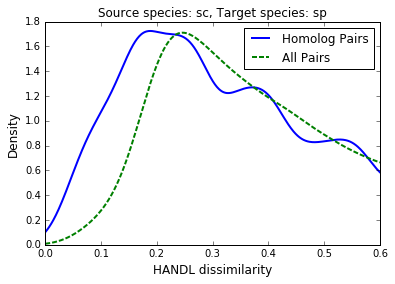

In [64]:
plt.plot(X_plot[:,0], np.exp(NLHdens), lw = line_width,
                 label = 'Homolog Pairs')
plt.plot(X_plot[:,0], np.exp(Ddens), '-.',
                 lw = line_width, ls = (0,(5,2)), label = 'All Pairs')
plt.ylabel('Density', size = font_size)
plt.xlabel('HANDL dissimilarity', size = font_size)
plt.title('Source species: {}, Target species: {}'.format(source, target))
plt.legend(loc='best', fontsize = font_size);